In [2]:
import numpy as np
import tensorflow as tf
import os

import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


from tensorflow_examples.models.pix2pix import pix2pix
from tensorflow.keras.models import load_model # type: ignore
from tensorflow import keras
from tensorflow.keras import backend as K # type: ignore

from glob import glob
from PIL import Image


In [3]:
size = (512, 512)
input_shape = [512, 512, 3]

In [4]:
def read_and_process_image(image_path):
    # Wczytaj obraz kolorowy (BGR)
    img = cv2.imread(f'all/images/{image_path}.jpg')

    img = img.astype(np.float32)  # konwertujemy typ danych na float32
    img = img / 255.0
    img = cv2.resize(img, size, interpolation=cv2.INTER_NEAREST)
       
    return img


def read_mask(image_name):
    # Wczytanie maski eksperckiej
    mask = cv2.imread(f'all/manual1/{image_name}.tif', cv2.IMREAD_GRAYSCALE)

    mask = mask.astype(np.float32)  # konwertujemy typ danych na float32
    mask = mask / 255.0
    mask = cv2.resize(mask, size)

    return mask

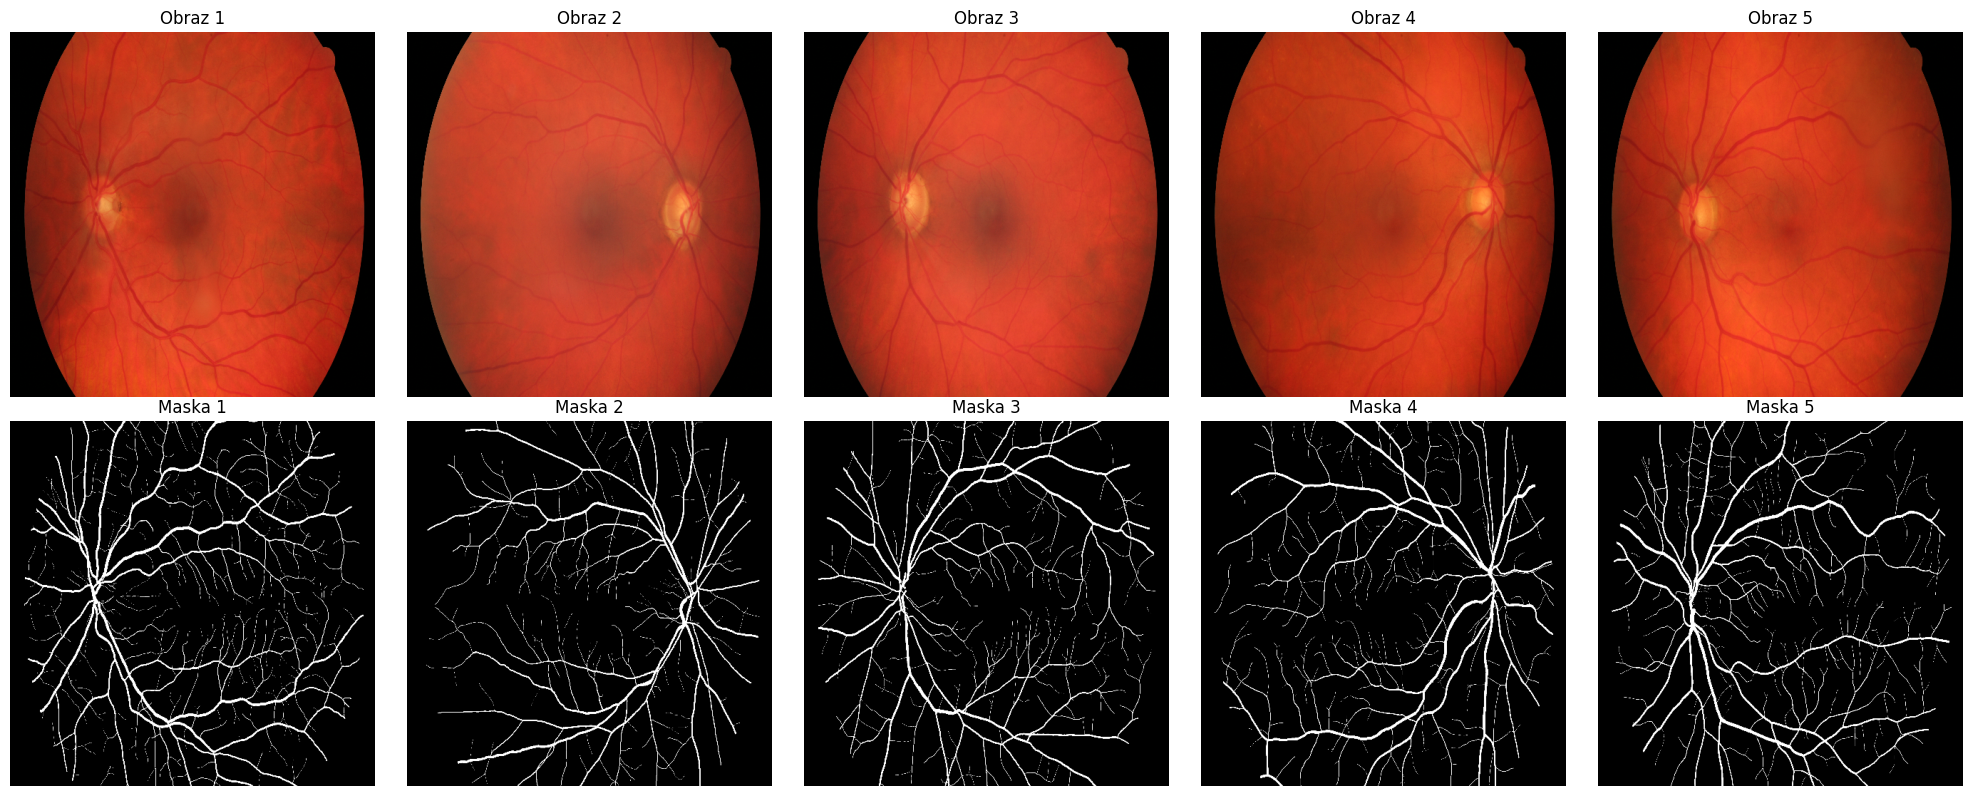

In [5]:
# Przykład użycia dla wielu obrazów
image_names = ['02_g', '03_g', '04_g', '05_g', '06_g']

processed_images = []
masks = []

for name in image_names:
    processed_img = read_and_process_image(name)
    mask = read_mask(name)
    processed_images.append(processed_img)
    masks.append(mask)
    

processed_images = np.array(processed_images)  # (N, H, W, 3)
masks = np.array(masks)                        # (N, H, W) lub (N, H, W, 1) w zależności od funkcji read_mask


plt.figure(figsize=(20, 8))

for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(cv2.cvtColor(processed_images[i], cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f'Obraz {i+1}')

for i in range(5):
    plt.subplot(2, 5, i+6)
    plt.imshow(masks[i], cmap='gray')
    plt.axis('off')
    plt.title(f'Maska {i+1}')

plt.tight_layout()
plt.show()

In [6]:
# Podział na zbiory treningowe i walidacyjne
X_train, X_valid, Y_train, Y_valid = train_test_split(processed_images, masks, test_size=0.33, random_state=42)

#wczytanie modelu

#czesto uzywany jako enkoder w unet
base_model = tf.keras.applications.MobileNetV2(input_shape, include_top=False)  #include_top=False -> Pomija ostatnią (klasyfikacyjną) warstwę modelu

# Pobieramy warstwy z różnych głębokości (do skip connections)
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Stwórz model enkodera
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)
down_stack.trainable = False

# Stwórz dekoder U-Net
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]


def unet_model(output_channels):
    # Enkoder
    inputs = tf.keras.layers.Input(shape=input_shape)
    skips = down_stack(inputs)
    x = skips[-1]  # głębokie cechy (najmniejszy rozmiar)

    skips = reversed(skips[:-1])

    # Dekoder + skip-connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    # Ostatnia warstwa wyjściowa — 1 kanał (lub output_channels)
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2,
        padding='same', activation='sigmoid'  # sigmoid do binarnej maski, softmax dla wielu klas
    )

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)




/var/folders/5x/6grr61gd1fv_14f2c7m11pqh0000gn/T/ipykernel_4959/1066555893.py:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape, include_top=False)  #include_top=False -> Pomija ostatnią (klasyfikacyjną) warstwę modelu


In [7]:
OUTPUT_CLASSES = 1  # jeśli segmentujesz tylko jedną klasę
model = unet_model(output_channels=OUTPUT_CLASSES)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # lub np. Dice loss jeśli masz
    metrics=['accuracy']
)


model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), epochs=20)


Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.5116 - loss: 0.6888 - val_accuracy: 0.6979 - val_loss: 0.5669
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6959 - loss: 0.5495 - val_accuracy: 0.7103 - val_loss: 0.4701
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8011 - loss: 0.4510 - val_accuracy: 0.9159 - val_loss: 0.3962
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9084 - loss: 0.3837 - val_accuracy: 0.9242 - val_loss: 0.3437
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9177 - loss: 0.3374 - val_accuracy: 0.9248 - val_loss: 0.3073
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9186 - loss: 0.3052 - val_accuracy: 0.9255 - val_loss: 0.2822
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9195 - loss: 0.2822 - val_accuracy: 0.9263 - val_loss: 0.2648
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9202 - loss: 0.2652 - val_accuracy: 0.9266 - val_loss: 0.2524
Epoch 9/20
1/1 ━

In [8]:
predictions = model.predict(X_train)

threshold = 0.14
pred_masks = (predictions > threshold).astype(np.uint8)


y_true = Y_train.reshape(-1)
y_pred = pred_masks.reshape(-1)

y_true = y_true.astype(np.uint8)
y_pred = y_pred.astype(np.uint8)

# y_true i y_pred muszą być binarne (0/1)
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

# Accuracy
accuracy = (tp + tn) / (tp + tn + fp + fn)

# Sensitivity (Recall, True Positive Rate)
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0

# Specificity (True Negative Rate)
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

# Mean arithmetic (średnia arytmetyczna sensitivity i specificity)
mean_arithmetic = (sensitivity + specificity) / 2

# Mean geometric (średnia geometryczna sensitivity i specificity)
mean_geometric = np.sqrt(sensitivity * specificity)

print("Accuracy:", accuracy)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Mean Arithmetic:", mean_arithmetic)
print("Mean Geometric:", mean_geometric)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step
Accuracy: 0.9155832926432291
Sensitivity: 0.47006261559373397
Specificity: 0.9425450573457127
Mean Arithmetic: 0.7063038364697234
Mean Geometric: 0.6656239140617408


In [9]:
# Przykład użycia dla wielu obrazów
image_names = ['07_g', '08_g', '09_g', '10_g', '11_g']

processed_images = []
masks = []

for name in image_names:
    processed_img = read_and_process_image(name)
    mask = read_mask(name)
    processed_images.append(processed_img)
    masks.append(mask)
    

processed_images = np.array(processed_images)  # (N, H, W, 3)
masks = np.array(masks)  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


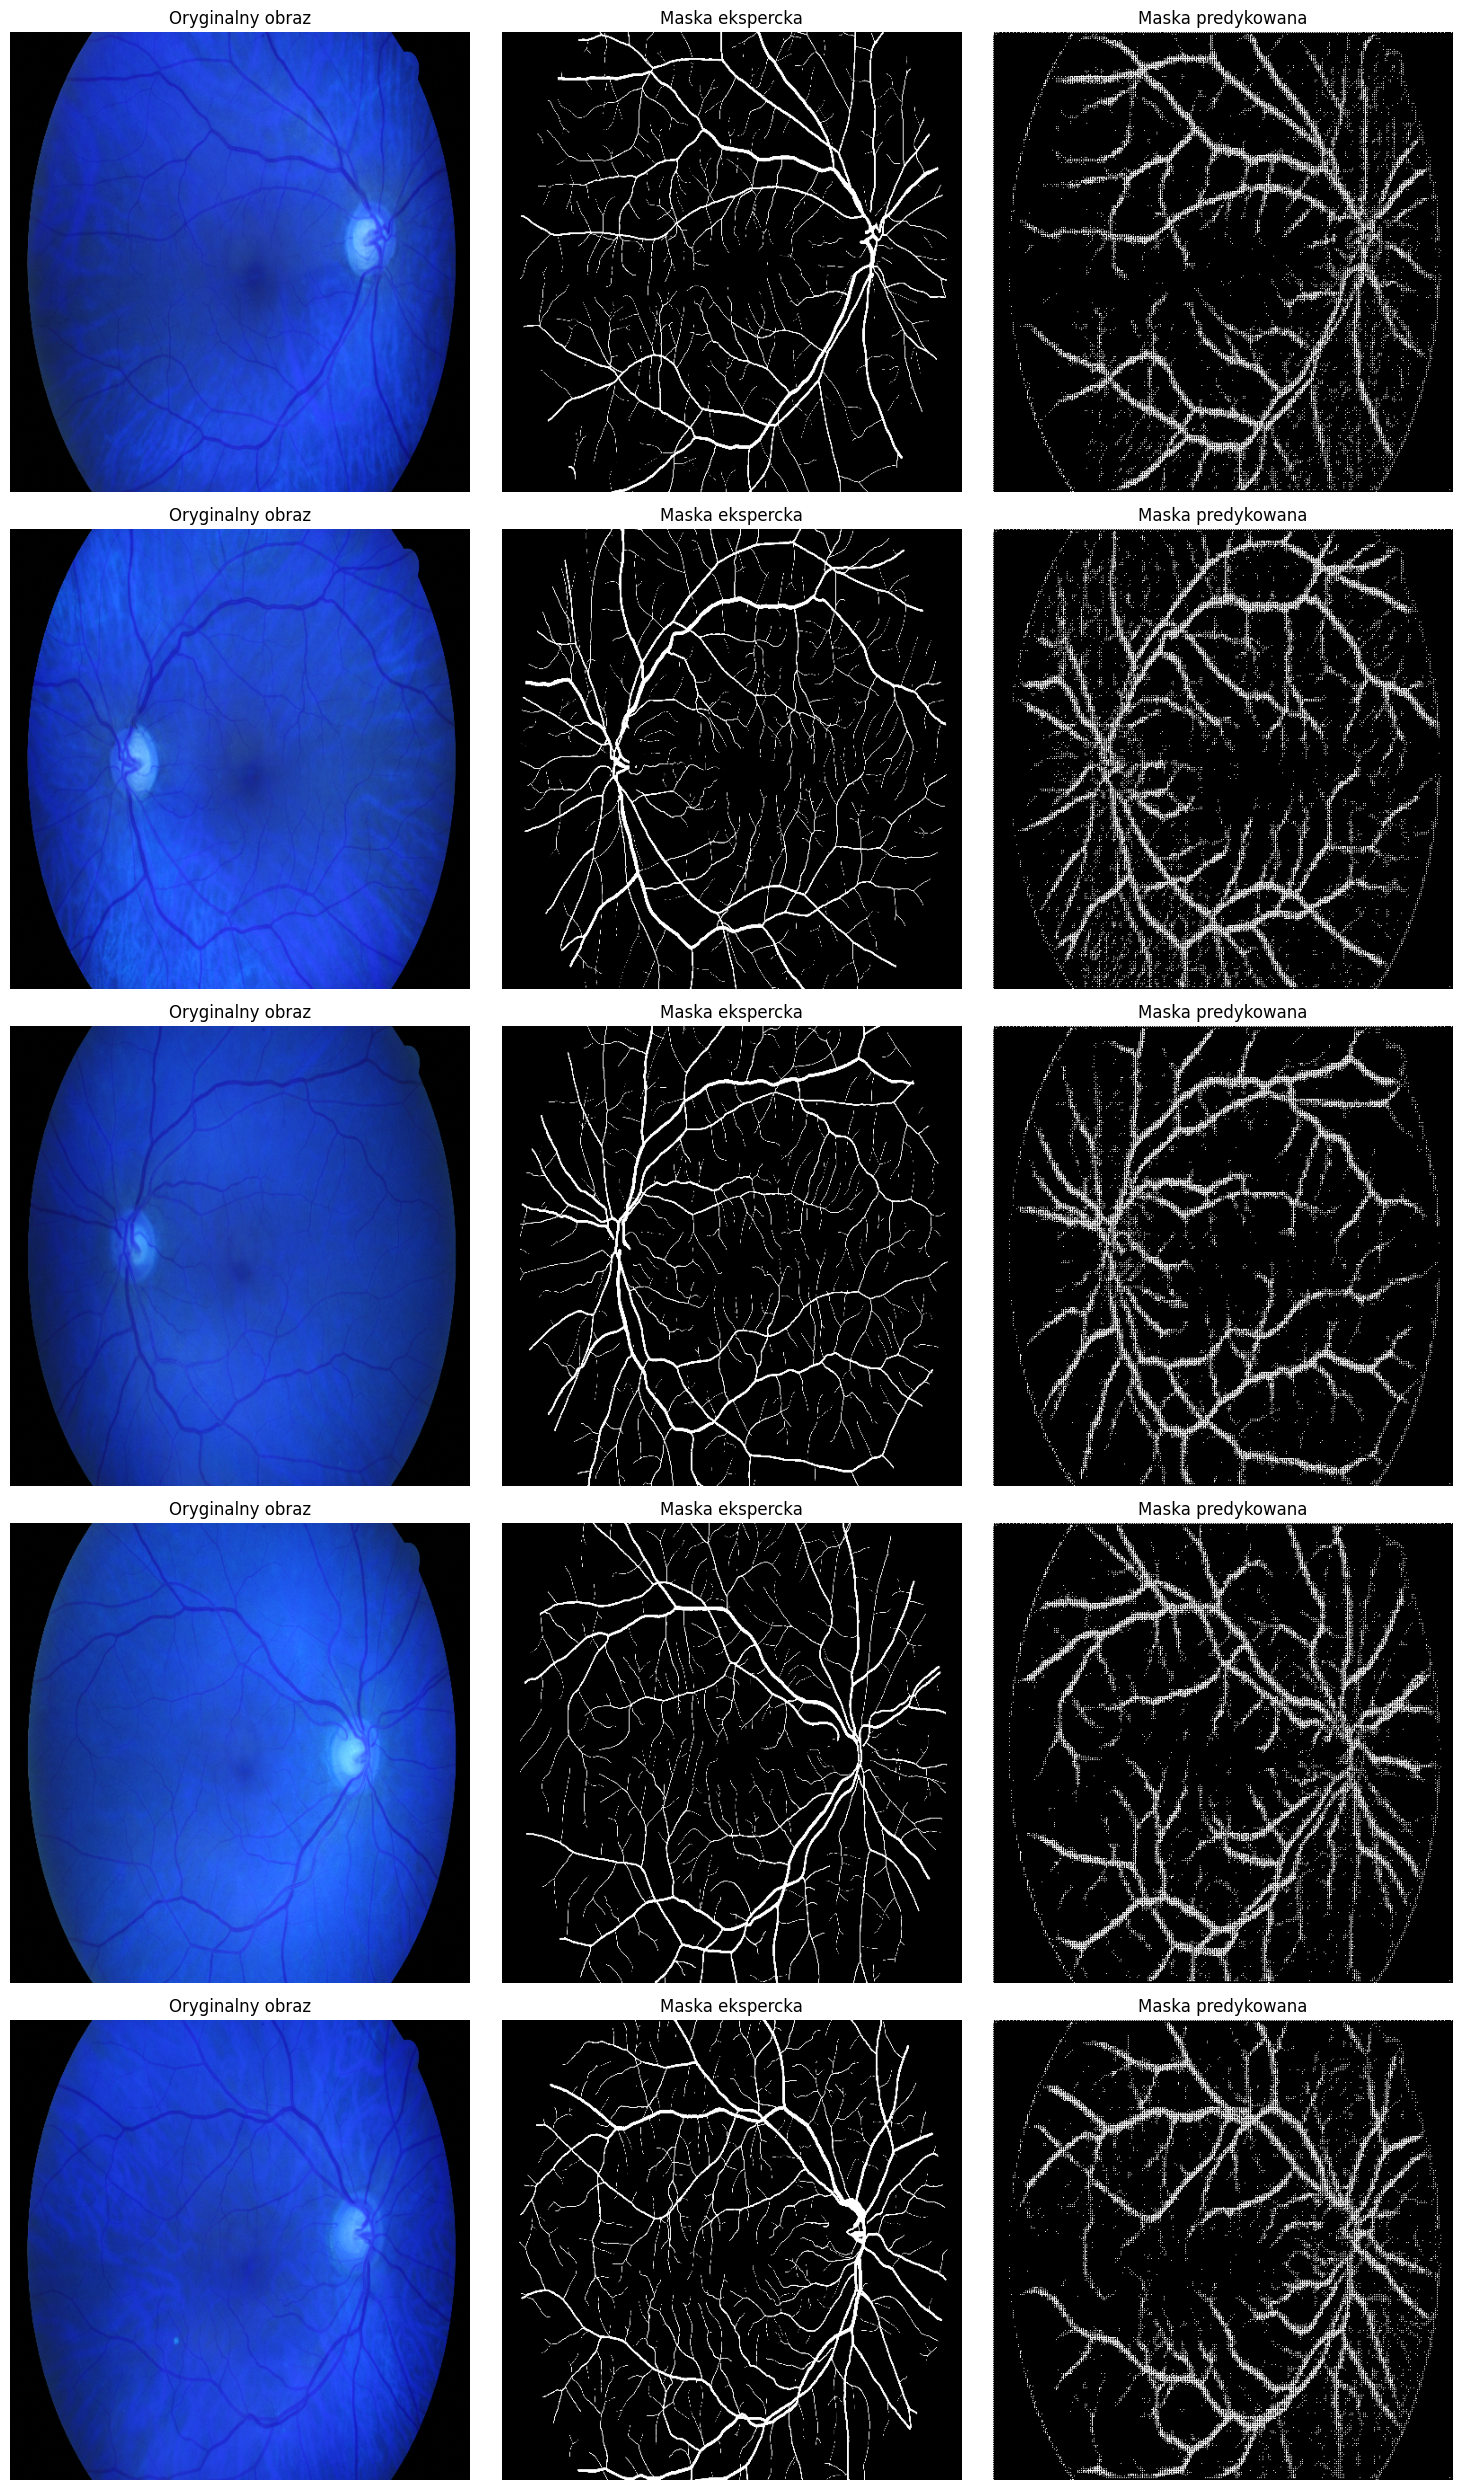

In [10]:
predictions = model.predict(processed_images)
pred_masks = (predictions > threshold).astype(np.uint8)

num_images = len(processed_images)

plt.figure(figsize=(15, num_images * 5))

for i in range(num_images):
    # Oryginalny obraz
    plt.subplot(num_images, 3, i * 3 + 1)
    plt.imshow(processed_images[i])
    plt.title("Oryginalny obraz")
    plt.axis('off')
    
    # Maska ekspercka (prawdziwa)
    plt.subplot(num_images, 3, i * 3 + 2)
    plt.imshow(masks[i], cmap='gray')
    plt.title("Maska ekspercka")
    plt.axis('off')
    
    # Maska predykowana
    plt.subplot(num_images, 3, i * 3 + 3)
    plt.imshow(pred_masks[i].squeeze(), cmap='gray')
    plt.title("Maska predykowana")
    plt.axis('off')

plt.tight_layout()
plt.show()